## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pandas as pd
from sklearn.metrics import roc_auc_score
from dataset import MultitaskDataset  # Replace with your actual module name

# Define transformations for training set and validation set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjusted size for ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjusted size for ResNet input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Parameters
batch_size = 32
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_folds = 10  # Number of folds

# Root directory for dataset
root_dir = '../../data/BiteCount'
folds_dir = './folds/'  # Directory containing fold CSVs


# DataFrame to store benchmarking results
results_df = pd.DataFrame(columns=['Model', 'Fold', 'Epoch', 'Val_Loss', 'Val_Accuracy', 'ROC_AUC'])
# Loop over each fold (1 to 10)
for fold in range(1, num_folds + 1):
    print(f"Fold {fold}/{num_folds}")
    
    # Load the corresponding training and validation CSV files for the current fold
    train_annotation_file = os.path.join(folds_dir, f'train_fold_{fold}.csv')
    val_annotation_file = os.path.join(folds_dir, f'test_fold_{fold}.csv')
    
    # Create dataset instances for the current fold
    train_dataset = MultitaskDataset(root_dir=root_dir, 
                                        annotation_file=train_annotation_file,
                                        transform=train_transforms,
                                        rgb=True)
    
    val_dataset = MultitaskDataset(root_dir=root_dir, 
                                    annotation_file=val_annotation_file,
                                    transform=val_transforms,
                                    rgb=True)

    # Create DataLoaders for the current fold
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    resnet_models = {
    'resnet18': models.resnet18(pretrained=True),
    'resnet34': models.resnet34(pretrained=True),
    'resnet50': models.resnet50(pretrained=True),
    'resnet101': models.resnet101(pretrained=True),
    'resnet152': models.resnet152(pretrained=True),
    }

    # Loop over ResNet models
    for model_name, model in resnet_models.items():
        print(f"Training {model_name}...")

        # Adjust final fully connected layer for binary classification
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 1)  # Binary classification
        model = model.to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

    
        best_val_acc = 0.0

        # Training loop for the current fold
        for epoch in range(num_epochs):
            model.train()  # Set the model to training mode
            running_loss = 0.0

            # Training loop
            for batch in train_loader:
                images = batch['rgb'].to(device)  # Get the RGB images
                labels = batch['label'].to(device).float()  # Convert labels to float for BCEWithLogitsLoss

                optimizer.zero_grad()  # Zero the gradients
                outputs = model(images)  # Forward pass
                loss = criterion(outputs.view(-1), labels)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimize weights

                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

            # Evaluation on validation set
            model.eval()  # Set the model to evaluation mode
            val_running_loss = 0.0
            correct = 0
            total = 0
            all_labels = []
            all_probs = []

            with torch.no_grad():
                for batch in val_loader:
                    images = batch['rgb'].to(device)  # Get the RGB images
                    labels = batch['label'].to(device).float()  # Convert labels to float for BCEWithLogitsLoss

                    outputs = model(images)
                    val_loss = criterion(outputs.view(-1), labels)
                    val_running_loss += val_loss.item()

                    # Collect true labels and predicted probabilities
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.extend(torch.sigmoid(outputs).view(-1).cpu().numpy())  # Apply sigmoid to get probabilities

                    # Calculate accuracy
                    predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid to get predictions
                    total += labels.size(0)
                    correct += (predicted.view(-1) == labels).sum().item()

            avg_val_loss = val_running_loss / len(val_loader)
            val_accuracy = correct / total

            roc_auc = roc_auc_score(all_labels, all_probs)
            print(f"Validation ROC AUC: {roc_auc:.4f}")

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Create a dictionary for current results
            epoch_result = {
                'Model': model_name,
                'Fold': fold,
                'Epoch': epoch + 1,
                'Val_Loss': avg_val_loss,
                'Val_Accuracy': val_accuracy,
                'ROC_AUC': roc_auc
            }

            # Use pd.concat() to add the row to results_df
            results_df = pd.concat([results_df, pd.DataFrame([epoch_result])], ignore_index=True)

            # Save the best model based on validation accuracy
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                torch.save(model.state_dict(), f'/media/sadat/sadat/resnet_benchmarks/best_{model_name}_fold{fold}.pth')
            
            
        print(f"Best Validation Accuracy for {model_name} in Fold {fold}: {best_val_acc:.4f}")
        

# Save the results dataframe to a CSV file
results_df.to_csv('resnet_benchmark_results_10fold.csv', index=False)
print("10-Fold Cross-Validation completed and results saved to resnet_benchmark_results_10fold.csv")


Fold 1/10


/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.6838
Validation ROC AUC: 0.9430
Validation Loss: 0.4855, Validation Accuracy: 0.7196
Epoch [2/10], Loss: 0.3668
Validation ROC AUC: 0.9767
Validation Loss: 0.2156, Validation Accuracy: 0.9082
Epoch [3/10], Loss: 0.2279
Validation ROC AUC: 0.9901
Validation Loss: 0.1291, Validation Accuracy: 0.9404
Epoch [4/10], Loss: 0.1702
Validation ROC AUC: 0.9746
Validation Loss: 0.2463, Validation Accuracy: 0.8983
Epoch [5/10], Loss: 0.1192
Validation ROC AUC: 0.9903
Validation Loss: 0.1211, Validation Accuracy: 0.9429
Epoch [6/10], Loss: 0.1381
Validation ROC AUC: 0.9898
Validation Loss: 0.1639, Validation Accuracy: 0.9380
Epoch [7/10], Loss: 0.1099
Validation ROC AUC: 0.9943
Validation Loss: 0.1181, Validation Accuracy: 0.9454
Epoch [8/10], Loss: 0.0817
Validation ROC AUC: 0.9935
Validation Loss: 0.0984, Validation Accuracy: 0.9603
Epoch [9/10], Loss: 0.0882
Validation ROC AUC: 0.9817
Validation Loss: 0.2997, Validation Accuracy: 0.8809
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.7417
Validation ROC AUC: 0.7576
Validation Loss: 0.6748, Validation Accuracy: 0.6606
Epoch [2/10], Loss: 0.4032
Validation ROC AUC: 0.9683
Validation Loss: 0.3059, Validation Accuracy: 0.8679
Epoch [3/10], Loss: 0.2472
Validation ROC AUC: 0.9743
Validation Loss: 0.2665, Validation Accuracy: 0.8841
Epoch [4/10], Loss: 0.1808
Validation ROC AUC: 0.9761
Validation Loss: 0.2071, Validation Accuracy: 0.9065
Epoch [5/10], Loss: 0.1315
Validation ROC AUC: 0.9798
Validation Loss: 0.1936, Validation Accuracy: 0.9146
Epoch [6/10], Loss: 0.1164
Validation ROC AUC: 0.9826
Validation Loss: 0.2591, Validation Accuracy: 0.9309
Epoch [7/10], Loss: 0.1042
Validation ROC AUC: 0.9880
Validation Loss: 0.1631, Validation Accuracy: 0.9370
Epoch [8/10], Loss: 0.1078
Validation ROC AUC: 0.9859
Validation Loss: 0.1715, Validation Accuracy: 0.9289
Epoch [9/10], Loss: 0.0748
Validation ROC AUC: 0.9885
Validation Loss: 0.1721, Validation Accuracy: 0.9167
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.7199
Validation ROC AUC: 0.9050
Validation Loss: 0.4563, Validation Accuracy: 0.8180
Epoch [2/10], Loss: 0.3654
Validation ROC AUC: 0.9532
Validation Loss: 0.6037, Validation Accuracy: 0.7830
Epoch [3/10], Loss: 0.2378
Validation ROC AUC: 0.9810
Validation Loss: 0.1687, Validation Accuracy: 0.9302
Epoch [4/10], Loss: 0.1656
Validation ROC AUC: 0.9791
Validation Loss: 0.2162, Validation Accuracy: 0.9277
Epoch [5/10], Loss: 0.1438
Validation ROC AUC: 0.9825
Validation Loss: 0.1821, Validation Accuracy: 0.9302
Epoch [6/10], Loss: 0.1201
Validation ROC AUC: 0.9888
Validation Loss: 0.1381, Validation Accuracy: 0.9352
Epoch [7/10], Loss: 0.1021
Validation ROC AUC: 0.9859
Validation Loss: 0.1553, Validation Accuracy: 0.9302
Epoch [8/10], Loss: 0.0876
Validation ROC AUC: 0.9852
Validation Loss: 0.1630, Validation Accuracy: 0.9302
Epoch [9/10], Loss: 0.0729
Validation ROC AUC: 0.9900
Validation Loss: 0.1283, Validation Accuracy: 0.9426
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.7107
Validation ROC AUC: 0.7484
Validation Loss: 0.8332, Validation Accuracy: 0.6404
Epoch [2/10], Loss: 0.3477
Validation ROC AUC: 0.9359
Validation Loss: 0.3357, Validation Accuracy: 0.8451
Epoch [3/10], Loss: 0.2327
Validation ROC AUC: 0.9743
Validation Loss: 0.2296, Validation Accuracy: 0.9213
Epoch [4/10], Loss: 0.1623
Validation ROC AUC: 0.9484
Validation Loss: 0.3971, Validation Accuracy: 0.8478
Epoch [5/10], Loss: 0.1670
Validation ROC AUC: 0.9127
Validation Loss: 0.4425, Validation Accuracy: 0.8399
Epoch [6/10], Loss: 0.1278
Validation ROC AUC: 0.9681
Validation Loss: 0.2505, Validation Accuracy: 0.9055
Epoch [7/10], Loss: 0.1058
Validation ROC AUC: 0.9664
Validation Loss: 0.3471, Validation Accuracy: 0.8530
Epoch [8/10], Loss: 0.0971
Validation ROC AUC: 0.9754
Validation Loss: 0.2194, Validation Accuracy: 0.8976
Epoch [9/10], Loss: 0.0812
Validation ROC AUC: 0.9899
Validation Loss: 0.1590, Validation Accuracy: 0.9370
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.6704
Validation ROC AUC: 0.9438
Validation Loss: 0.3028, Validation Accuracy: 0.8265
Epoch [2/10], Loss: 0.3938
Validation ROC AUC: 0.9689
Validation Loss: 0.3558, Validation Accuracy: 0.8217
Epoch [3/10], Loss: 0.2570
Validation ROC AUC: 0.9928
Validation Loss: 0.1513, Validation Accuracy: 0.9398
Epoch [4/10], Loss: 0.1772
Validation ROC AUC: 0.9919
Validation Loss: 0.1184, Validation Accuracy: 0.9470
Epoch [5/10], Loss: 0.1375
Validation ROC AUC: 0.9861
Validation Loss: 0.1472, Validation Accuracy: 0.9325
Epoch [6/10], Loss: 0.1339
Validation ROC AUC: 0.9918
Validation Loss: 0.1220, Validation Accuracy: 0.9422
Epoch [7/10], Loss: 0.1184
Validation ROC AUC: 0.9938
Validation Loss: 0.0945, Validation Accuracy: 0.9518
Epoch [8/10], Loss: 0.0762
Validation ROC AUC: 0.9945
Validation Loss: 0.1026, Validation Accuracy: 0.9566
Epoch [9/10], Loss: 0.0619
Validation ROC AUC: 0.9944
Validation Loss: 0.1175, Validation Accuracy: 0.9542
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.7036
Validation ROC AUC: 0.8035
Validation Loss: 0.5226, Validation Accuracy: 0.7208
Epoch [2/10], Loss: 0.3400
Validation ROC AUC: 0.9258
Validation Loss: 0.3437, Validation Accuracy: 0.8222
Epoch [3/10], Loss: 0.2218
Validation ROC AUC: 0.9203
Validation Loss: 0.3724, Validation Accuracy: 0.8203
Epoch [4/10], Loss: 0.1671
Validation ROC AUC: 0.9553
Validation Loss: 0.2556, Validation Accuracy: 0.8547
Epoch [5/10], Loss: 0.1464
Validation ROC AUC: 0.9602
Validation Loss: 0.2721, Validation Accuracy: 0.8738
Epoch [6/10], Loss: 0.1261
Validation ROC AUC: 0.9563
Validation Loss: 0.2551, Validation Accuracy: 0.8681
Epoch [7/10], Loss: 0.0929
Validation ROC AUC: 0.9453
Validation Loss: 0.3358, Validation Accuracy: 0.8241
Epoch [8/10], Loss: 0.0926
Validation ROC AUC: 0.9680
Validation Loss: 0.2238, Validation Accuracy: 0.8662
Epoch [9/10], Loss: 0.0898
Validation ROC AUC: 0.9675
Validation Loss: 0.2184, Validation Accuracy: 0.8891
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.7241
Validation ROC AUC: 0.8386
Validation Loss: 0.5337, Validation Accuracy: 0.6970
Epoch [2/10], Loss: 0.3629
Validation ROC AUC: 0.9364
Validation Loss: 0.3580, Validation Accuracy: 0.8485
Epoch [3/10], Loss: 0.2093
Validation ROC AUC: 0.9373
Validation Loss: 0.4385, Validation Accuracy: 0.8298
Epoch [4/10], Loss: 0.1704
Validation ROC AUC: 0.9502
Validation Loss: 0.3327, Validation Accuracy: 0.8578
Epoch [5/10], Loss: 0.1345
Validation ROC AUC: 0.9496
Validation Loss: 0.3363, Validation Accuracy: 0.8718
Epoch [6/10], Loss: 0.1208
Validation ROC AUC: 0.9559
Validation Loss: 0.3083, Validation Accuracy: 0.8951
Epoch [7/10], Loss: 0.1029
Validation ROC AUC: 0.9601
Validation Loss: 0.3259, Validation Accuracy: 0.8858
Epoch [8/10], Loss: 0.0881
Validation ROC AUC: 0.9678
Validation Loss: 0.2771, Validation Accuracy: 0.9044
Epoch [9/10], Loss: 0.0623
Validation ROC AUC: 0.9545
Validation Loss: 0.4737, Validation Accuracy: 0.8718
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.6565
Validation ROC AUC: 0.8477
Validation Loss: 0.5515, Validation Accuracy: 0.6864
Epoch [2/10], Loss: 0.3196
Validation ROC AUC: 0.8468
Validation Loss: 0.6023, Validation Accuracy: 0.6914
Epoch [3/10], Loss: 0.2081
Validation ROC AUC: 0.9364
Validation Loss: 0.3312, Validation Accuracy: 0.8395
Epoch [4/10], Loss: 0.1528
Validation ROC AUC: 0.9278
Validation Loss: 0.3764, Validation Accuracy: 0.8469
Epoch [5/10], Loss: 0.1418
Validation ROC AUC: 0.9203
Validation Loss: 0.3896, Validation Accuracy: 0.8222
Epoch [6/10], Loss: 0.1081
Validation ROC AUC: 0.9176
Validation Loss: 0.4354, Validation Accuracy: 0.8296
Epoch [7/10], Loss: 0.0990
Validation ROC AUC: 0.9222
Validation Loss: 0.3802, Validation Accuracy: 0.8296
Epoch [8/10], Loss: 0.0769
Validation ROC AUC: 0.9552
Validation Loss: 0.3354, Validation Accuracy: 0.8593
Epoch [9/10], Loss: 0.0765
Validation ROC AUC: 0.9432
Validation Loss: 0.3445, Validation Accuracy: 0.8889
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.7039
Validation ROC AUC: 0.8494
Validation Loss: 0.4780, Validation Accuracy: 0.7309
Epoch [2/10], Loss: 0.3320
Validation ROC AUC: 0.9239
Validation Loss: 0.3428, Validation Accuracy: 0.8247
Epoch [3/10], Loss: 0.1984
Validation ROC AUC: 0.9377
Validation Loss: 0.3808, Validation Accuracy: 0.8173
Epoch [4/10], Loss: 0.1676
Validation ROC AUC: 0.9354
Validation Loss: 0.3102, Validation Accuracy: 0.8222
Epoch [5/10], Loss: 0.1288
Validation ROC AUC: 0.9473
Validation Loss: 0.3666, Validation Accuracy: 0.8519
Epoch [6/10], Loss: 0.0960
Validation ROC AUC: 0.9421
Validation Loss: 0.3606, Validation Accuracy: 0.8543
Epoch [7/10], Loss: 0.0924
Validation ROC AUC: 0.9372
Validation Loss: 0.4186, Validation Accuracy: 0.8148
Epoch [8/10], Loss: 0.0861
Validation ROC AUC: 0.9538
Validation Loss: 0.3332, Validation Accuracy: 0.8593
Epoch [9/10], Loss: 0.0641
Validation ROC AUC: 0.9576
Validation Loss: 0.4149, Validation Accuracy: 0.8346
Epoch [10/10], L

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can 

Training resnet18...
Epoch [1/10], Loss: 0.6928
Validation ROC AUC: 0.8312
Validation Loss: 0.5969, Validation Accuracy: 0.7312
Epoch [2/10], Loss: 0.3906
Validation ROC AUC: 0.9848
Validation Loss: 0.1626, Validation Accuracy: 0.9443
Epoch [3/10], Loss: 0.2256
Validation ROC AUC: 0.9681
Validation Loss: 0.2509, Validation Accuracy: 0.8959
Epoch [4/10], Loss: 0.1702
Validation ROC AUC: 0.9850
Validation Loss: 0.1682, Validation Accuracy: 0.9322
Epoch [5/10], Loss: 0.1298
Validation ROC AUC: 0.9913
Validation Loss: 0.1337, Validation Accuracy: 0.9492
Epoch [6/10], Loss: 0.1201
Validation ROC AUC: 0.9888
Validation Loss: 0.1426, Validation Accuracy: 0.9492
Epoch [7/10], Loss: 0.1076
Validation ROC AUC: 0.9921
Validation Loss: 0.1182, Validation Accuracy: 0.9588
Epoch [8/10], Loss: 0.0828
Validation ROC AUC: 0.9887
Validation Loss: 0.1325, Validation Accuracy: 0.9492
Epoch [9/10], Loss: 0.0835
Validation ROC AUC: 0.9892
Validation Loss: 0.1382, Validation Accuracy: 0.9419
Epoch [10/10], L

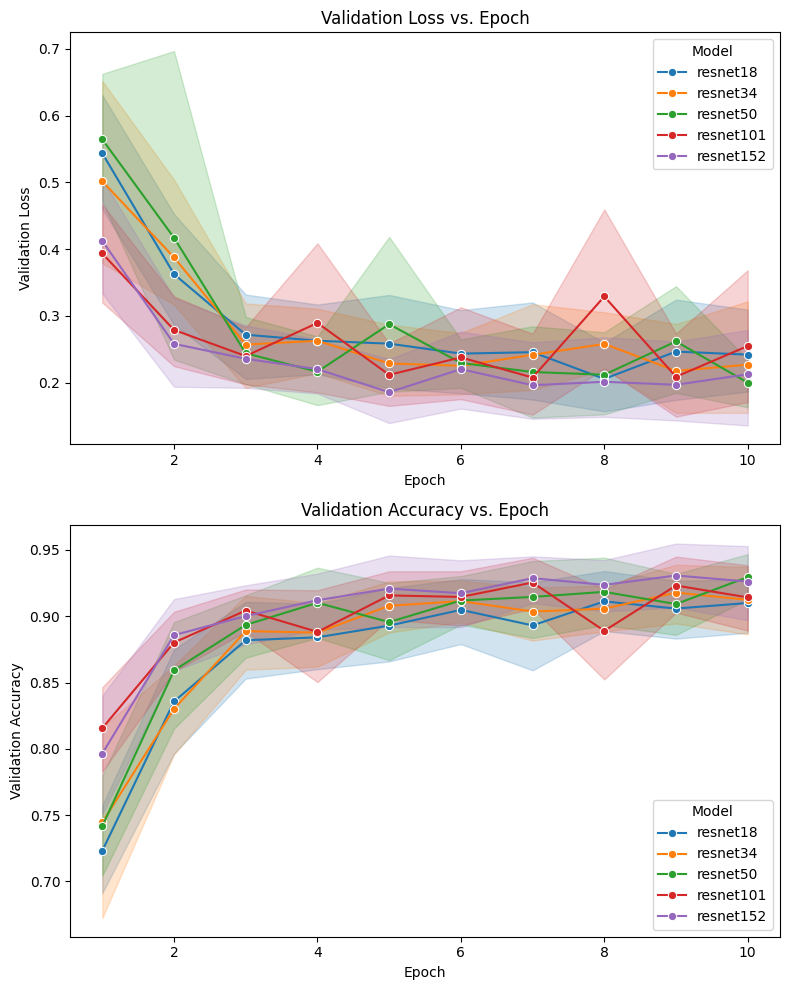

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Create a figure with 2 subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot Val_Loss against Epoch
sns.lineplot(x='Epoch', y='Val_Loss', hue='Model', marker='o', data=results_df, ax=axes[0])
axes[0].set_title('Validation Loss vs. Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')

# Plot Val_Accuracy against Epoch
sns.lineplot(x='Epoch', y='Val_Accuracy', hue='Model', marker='o', data=results_df, ax=axes[1])
axes[1].set_title('Validation Accuracy vs. Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')

# Adjust layout
plt.tight_layout()
plt.show()

In [3]:
batch['rgb'].shape

torch.Size([29, 3, 224, 224])

In [4]:
batch['label']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1])